# Histograma puntos visitante

Isabel Afán de Ribera
09/12/2020

In [1]:
# instalacion de spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
# definimos las variables de entorno, Java y Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [3]:
# generar Spark context
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# carga del archivo partidosLigaNBA
# establecemos conexion entre el RDD y los datos
data_file = "./partidosLigaNBA.csv" 
nba_data = sc.textFile(data_file)

In [6]:
# recuento de registros, count es un tipo de funcion de accion
nba_data.count()

12908

In [7]:
# take devuelve una muestra de los datos, es una funcion de accion
nba_data.take(5)

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74']

In [8]:
head_nba_data = nba_data.take(1)[0]

In [9]:
# comprobamos lo que contiene la cabecera
head_nba_data

'Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1'

In [11]:
# primero filtramos con una funcion lambda para quitar la cabecera (transformacion);
# despues aplicamos el metodo map con una funcion split en su interior para separar los elementos y 
# quedarnos con el ultimo que corresponde a puntos visitantes;
# usamos la funcion creada en el paso anteior para filtrar solo los datos numericos;
# aplicamos otro map para convertir los puntos de tipo string a numerico 
wh_nba_data = nba_data.filter(lambda s: s != head_nba_data) \
                      .map(lambda s: s.split(":")[-1]) \
                      .filter(isd) \
                      .map(lambda d_pvisit: int(d_pvisit))
wh_nba_data.take(1500)

[96,
 93,
 106,
 74,
 120,
 119,
 101,
 112,
 104,
 102,
 106,
 80,
 99,
 95,
 101,
 103,
 102,
 85,
 110,
 87,
 120,
 91,
 69,
 113,
 92,
 98,
 96,
 123,
 89,
 111,
 78,
 88,
 133,
 82,
 88,
 92,
 115,
 119,
 88,
 97,
 103,
 95,
 107,
 83,
 91,
 104,
 89,
 104,
 112,
 103,
 87,
 119,
 104,
 105,
 119,
 89,
 94,
 93,
 88,
 98,
 96,
 103,
 97,
 115,
 87,
 106,
 96,
 103,
 104,
 107,
 101,
 85,
 102,
 103,
 110,
 91,
 101,
 92,
 71,
 106,
 101,
 96,
 91,
 100,
 118,
 90,
 82,
 95,
 72,
 72,
 113,
 103,
 122,
 82,
 117,
 91,
 99,
 86,
 105,
 103,
 113,
 102,
 107,
 117,
 91,
 116,
 110,
 104,
 90,
 84,
 95,
 102,
 108,
 95,
 88,
 103,
 105,
 112,
 123,
 92,
 99,
 122,
 103,
 118,
 89,
 70,
 92,
 123,
 90,
 110,
 100,
 108,
 115,
 105,
 117,
 73,
 105,
 82,
 87,
 109,
 106,
 104,
 105,
 100,
 101,
 125,
 88,
 102,
 83,
 107,
 105,
 112,
 114,
 82,
 98,
 116,
 105,
 111,
 98,
 94,
 101,
 89,
 79,
 110,
 86,
 93,
 127,
 101,
 128,
 107,
 99,
 83,
 111,
 98,
 105,
 113,
 87,
 101,
 93,
 99,
 

In [12]:
# tipo del RDD
type(wh_nba_data)

pyspark.rdd.PipelinedRDD

In [13]:
# minimo puntos
wh_nba_data.min()

59

In [14]:
# maximo puntos
wh_nba_data.max()

168

In [15]:
# intervalos entre el minimo y el maximo
# diferencia entre maximo y minimo entre 10 divisiones
(wh_nba_data.max() - wh_nba_data.min()) / 10

10.9

In [16]:
# definimos una funcion para las divisiones del histograma 
# al min de puntos le sumamos la diferencia con el max de forma acumulativa hasta llegar a la puntuacion max
def inter(x):
  if x<69.9:
    return 'int1'
  elif x <80.8:
    return 'int2'
  elif x<91.7:
    return 'int3'
  elif x<102.6:
    return 'int4'
  elif x<113.5:
    return 'int5'
  elif x<124.4:
    return 'int6'
  elif x<135.3:
    return 'int7'
  elif x<146.2:
    return 'int8'
  elif x<157.1:
    return 'int9'
  elif x<=168:
    return 'int10'

In [17]:
# el puntuaje 160 corresponde al intervalo 10
inter(160)

'int10'

In [18]:
# con reduceByKey hacemos groupby y map en un solo paso para la frecuencia de los intervalos
# con collect transformamos los elementos del RDD en una lista
nba_data_hist = nba_data.filter(lambda s: s != head_nba_data) \
                      .map(lambda s: s.split(":")[-1]) \
                      .filter(lambda s_pvisit: s_pvisit.isdigit()) \
                      .map(lambda d_pvisit: int(d_pvisit)) \
                      .map(lambda x : (inter(x),1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .collect()
nba_data_hist

[('int4', 4287),
 ('int5', 3832),
 ('int6', 1717),
 ('int8', 59),
 ('int9', 5),
 ('int2', 439),
 ('int3', 2125),
 ('int1', 37),
 ('int7', 395),
 ('int10', 1)]

In [19]:
# comprobamos que ahora hay una lista
type(nba_data_hist)

list

In [20]:
# ordenamos la lista
nba_data_hist.sort()

In [22]:
# creamos un data frame para ello primero importamos la libreria pandas
import pandas as pd
df_nba_hist = pd.DataFrame(nba_data_hist)

In [23]:
# comprobamos que tenemos un dataframe
type(df_nba_hist)

pandas.core.frame.DataFrame

In [24]:
import numpy as np

In [25]:
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x7f62519e7f98>,
 <a list of 10 Text major ticklabel objects>)

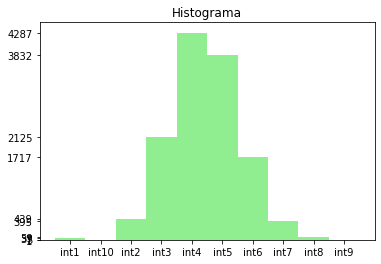

In [27]:
# definimos los parametros del histograma
labels, ys = zip(*nba_data_hist)
xs = np.arange(len(labels)) 
width = 1

# representamos el histograma
plt.bar(xs, ys, width, align='center', color = 'lightgreen');
plt.title("Histograma");

plt.xticks(xs, labels)
plt.yticks(ys)